# Monte Carlo simulation of the one-dimensional Ising model at $B=0$

The one-dimensional Ising model consists of $N$ spins arranged periodically on a line. Each spin can take the values $s_i\in\{-1,+1\}$. The energy $\mathcal{H}$ in the absence of a magnetic field is given by

$$\mathcal{H}=-J\sum_{i=1}^{N}s_is_{i+1}$$

To avoid boundary effects, periodic boundary conditions are employed, such that $s_{N+1}\equiv s_1$.

---

First we define a function that calculates the energy at time $t$

In [1]:
function get_energy(spin_vec::Vector{Int64}, J::Int64)
    """ Calculate the energy E of a spin configuration
    spin_vec = array of spins
    J        = neighbour spins coupling constant
    
    return E
    """
    nspins = length(spin_vec)
    eng    = 0.0
    
    for (sid,s) ∈ enumerate(spin_vec)
        snext = (sid==nspins ? spin_vec[1] : spin_vec[sid+1])
        eng += -J*s*snext
    end
    
    return eng
end;


We define another function that evolves the magnetization $M$ and energy $E$ according to the Monte Carlo algorithm:
1. Pick a spin $s_i$ from the configuration at random
2. Calculate the energy difference $\Delta{E}$ between the new configuration and the original one
3. Pick a random number $r\in(0,1)$
4. Accept the move only if $r<\min(1,e^{-\Delta/k_BT})$
5. Accumulate results
6. Go back to step 1

In [2]:
function evolve_M_E(spin_vec::Vector{Int64}, nsteps::Int64, kT::Float64, J::Int64)
    """ Generate M(t) and E(t) using importance sampling
    spin_vec = vector of spins
    nsteps   = number of steps
    kT       = temperature
    J        = neighbour spins coupling constant
    
    return ( M(t), E(t) )
    """
    # initialize variables
    nspins  = length(spin_vec)
    m_t     = sum(spin_vec)
    m_t_vec = zeros(Int64, nsteps)
    e_t_vec = zeros(Int64, nsteps)

    # evolve
    for step ∈ 1:nsteps
        # pick a spin and get neighbours
        sid::Int64 = rand(1:nspins)
        stest = spin_vec[sid]
        sprev = sid==1 ? spin_vec[nspins] : spin_vec[sid-1]
        snext = sid==nspins ? spin_vec[1] : spin_vec[sid+1]
        
        # calculate energy difference
        Δ::Float64 = 2.0*J*stest*(sprev + snext)
        
        # accept or reject move
        if rand() < min(1.0,exp(-Δ/kT))
            spin_vec[sid] = -stest
        end
        
        # accumulate results
        m_t_vec[step] = sum(spin_vec)
        e_t_vec[step] = get_energy(spin_vec, J)
    end
    
    return (m_t_vec, e_t_vec)
end;

In [3]:
# Set parameters
nspins   = 100
nsteps   = 2000
step_vec = collect(1:nsteps)
spin_vec = ones(Int64,nspins)
kT1      = 0.25
kT2      = 2.0
J        = 1

# Get magnetization and energy time evolution
m1_t_vec, e1_t_vec = evolve_M_E(spin_vec, nsteps, kT1, J);
m2_t_vec, e2_t_vec = evolve_M_E(spin_vec, nsteps, kT2, J);

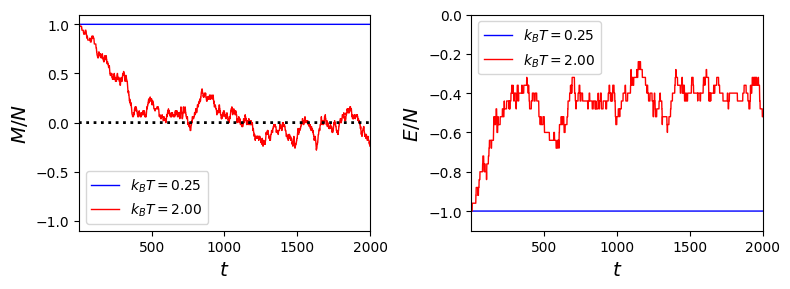

In [4]:
using PyPlot
PyPlot.rc("figure", figsize = (8,3))

# Magnetization
subplot(121)
plot(step_vec, m1_t_vec/nspins, lw=1, c="b", label=L"$k_BT=0.25$")
plot(step_vec, m2_t_vec/nspins, lw=1, c="r", label=L"$k_BT=2.00$")
plot(step_vec, zeros(nsteps), ls=":", lw=2, c="k")

xlim(first(step_vec), nsteps)
ylim(-1.1,1.1)
xlabel(L"$t$", size="x-large")
ylabel(L"$M/N$", size="x-large")
legend();

# Energy
subplot(122)
plot(step_vec, e1_t_vec/nspins, lw=1, c="b", label=L"$k_BT=0.25$")
plot(step_vec, e2_t_vec/nspins, lw=1, c="r", label=L"$k_BT=2.00$")

xlim(first(step_vec), nsteps)
ylim(-1.1,0.0)
xlabel(L"$t$", size="x-large")
ylabel(L"$E/N$", size="x-large")
legend();

tight_layout()

We observe that for "cold" temperatures the magnetization stays constant, whereas for "hot" temperatures the magnetization decays and fluctuats around zero.

For the energy, "cold" temperatures keep it at the minimum value. "Hot" temperatures increase the energy until it reaches a maximum around which it will fluctuate.

---

Now we define a function that calculates average values $\langle M\rangle$, $\langle E\rangle$ at a given temperature $k_BT$.

In [5]:
function average_M_E(nspins::Int64, nsteps::Int64, kT_vec::Vector{Float64}, J::Int64, truncate::Int64)
    """ Get average values of M(t) and E(t) at given kT
    nspins = number of spins
    nsteps = number of steps
    kT_vec = array of temperatures kT
    
    return ( <M>, <M^2>, <E>, <E^2> )
    """
    # initialize variables
    nsamples = 0
    spin_vec = ones(Int64,nspins)
    mav_vec  = zeros(Float64,length(kT_vec))
    m2av_vec = zeros(Float64,length(kT_vec))
    eav_vec  = zeros(Float64,length(kT_vec))
    e2av_vec = zeros(Float64,length(kT_vec))
    
    # iterate over temperatures
    for (i,kT) ∈ enumerate(kT_vec)
        # get time evolution M(t) and E(t)
        mt_vec, et_vec = evolve_M_E(spin_vec, nsteps, kT, J)
        
        # truncate time evolution arrays
        mt_vec_dum = mt_vec[truncate:nspins:nsteps]
        et_vec_dum = et_vec[truncate:nspins:nsteps]
        
        # accumulate results
        mav_vec[i] = sum(mt_vec_dum)
        m2av_vec[i] = sum(mt_vec_dum.^2)
        eav_vec[i] = sum(et_vec_dum)
        e2av_vec[i] = sum(et_vec_dum.^2)
        nsamples = length(mt_vec_dum)
    end
    
    mav_vec /= nsamples
    m2av_vec /= nsamples
    eav_vec /= nsamples
    e2av_vec /= nsamples
    
    return (mav_vec, m2av_vec, eav_vec, e2av_vec)
end;

We can compare the Monte Carlo results against curves predicted by the theory

$$ \langle E \rangle^\text{Theory} = -NJ\tanh\left(\frac{J}{k_BT}\right) \quad\text{and}\quad C^\text{Theory} = Nk_B\left(\frac{J}{k_BT}\right)^2\text{sech}^2\left(\frac{J}{k_BT}\right). $$

For the Monte Carlo simulations, the heat capacity $C$ can be calculated as

$$ C^\text{MC} = \frac{\langle E^2 \rangle - \langle E \rangle^2}{(k_BT)^2}. $$

In [6]:
# set parameters
nspins   = 100
nsteps   = 2000000
truncate = 2000
J        = 1

# get averages
kT_vec = collect(0.1:0.2:2.0)
mav_vec, m2av_vec, eav_vec, e2av_vec = average_M_E(nspins, nsteps, kT_vec, J, truncate)
cav_vec = (e2av_vec - eav_vec.^2) ./ (kT_vec.^2);

# get theory curves
kT_theory = LinRange(first(kT_vec), last(kT_vec), 100)
e_theory = [-tanh(1.0/kT) for kT ∈ kT_theory]
c_theory = [(sech(1.0/kT)/kT).^2 for kT ∈ kT_theory];

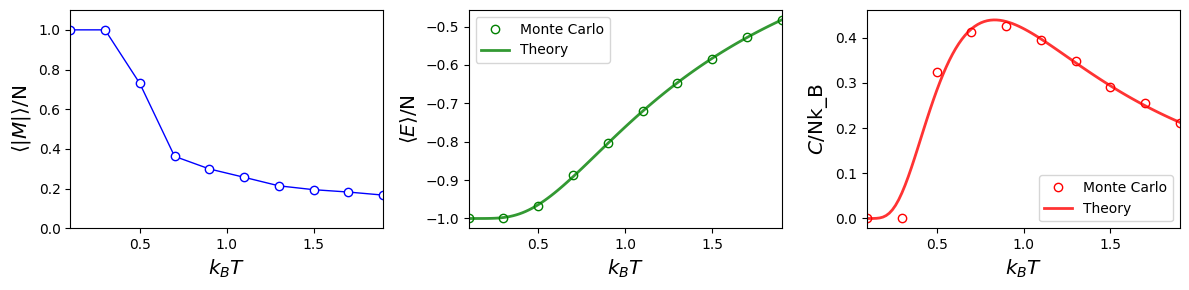

In [7]:
using PyPlot
PyPlot.rc("figure", figsize = (12,3))

# Magnetization
subplot(131)
plot(kT_vec, sqrt.(m2av_vec)/nspins,
    lw=1, marker="o", ms=6, mfc="w", c="b")

xlim(first(kT_vec), last(kT_vec))
ylim(0.0,1.1)
xlabel(L"$k_BT$", size="x-large")
ylabel(L"$\langle |M|\rangle$/N", size="x-large")

# Energy
subplot(132)
plot(kT_vec, eav_vec/nspins,
    lw=0, marker="o", ms=6, mfc="w", c="g", label="Monte Carlo")
plot(kT_theory, e_theory,
    lw=2, c="g", alpha=0.8, label="Theory")

xlim(first(kT_vec), last(kT_vec))
xlabel(L"$k_BT$", size="x-large")
ylabel(L"$\langle E\rangle$/N", size="x-large")
legend()

# Heat capacity
subplot(133)
plot(kT_vec, cav_vec/nspins,
    lw=0, marker="o", ms=6, mfc="w", c="r", label="Monte Carlo")
plot(kT_theory, c_theory,
    lw=2, c="r", alpha=0.8, label="Theory")

xlim(first(kT_vec), last(kT_vec))
xlabel(L"$k_BT$", size="x-large")
ylabel(L"$C$/Nk_B", size="x-large")
legend()

tight_layout();